In [32]:
import glob
import matplotlib.pyplot as plt
import numpy as np
import cv2 as cv
from tqdm import tqdm  #usada para mostrar barra de progresso

Entrega Juan Pacheco - Santiago Cruz

In [33]:
#carga de las imagenes
imagenes = glob.glob('../imagenes/*.jpg')
imagenes = imagenes[::-1] #se invierte en orden de las imagenes
print(len(imagenes))

26


# Esta parte es exploratoria para ver que preprocesamiento, detector y emparejador es mejor para los propósitos.

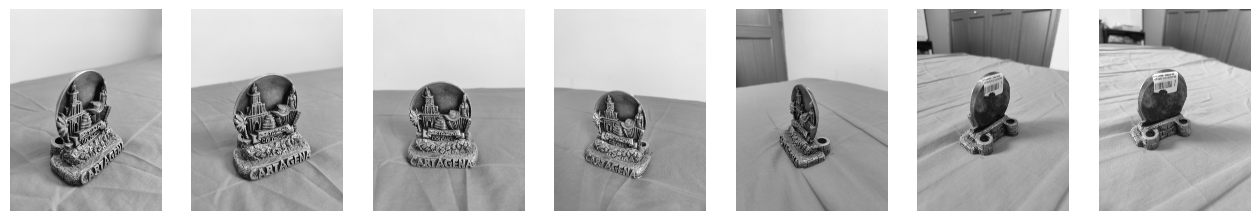

In [34]:
#Se muestran algunas de las imagenes a usar
fig, axes = plt.subplots(1, 7, figsize=(16, 4))
indices = [0, 2, 6, 8, 12, 16, 17]
for ax, idx in zip(axes, indices):
    im = cv.imread(imagenes[idx], cv.IMREAD_GRAYSCALE)
    ax.imshow(im, cmap='gray')
    ax.axis('off')
plt.show()

### Intento de emparejamiento, solo usando imagen en gris sin otro cambio, sift y flann

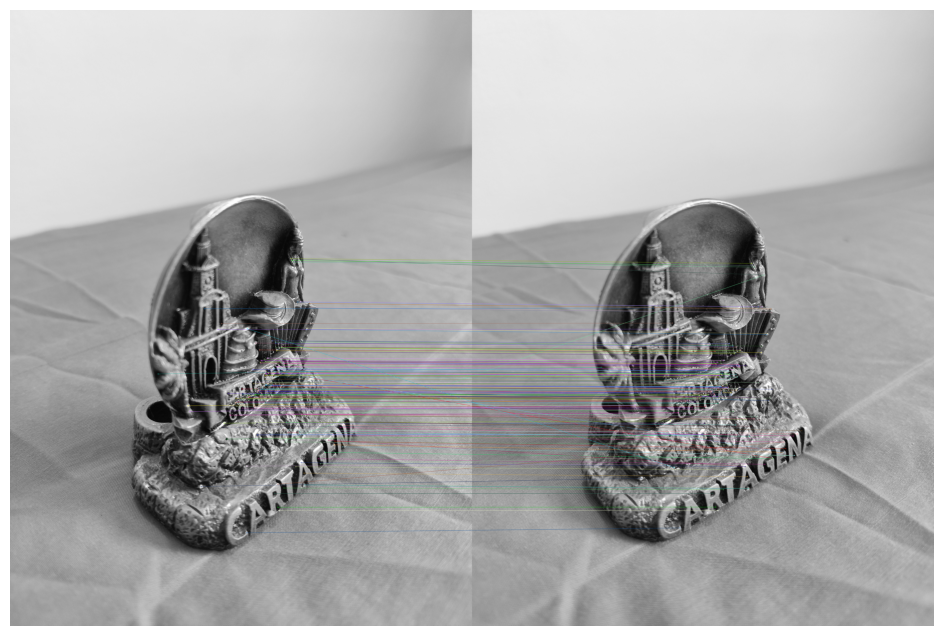

In [35]:
imagen1 = cv.imread(imagenes[0], cv.IMREAD_GRAYSCALE)
imagen2 = cv.imread(imagenes[1], cv.IMREAD_GRAYSCALE) #-> se tuvo un buen emparejamiento

#imagen1 = cv.imread(imagenes[5], cv.IMREAD_GRAYSCALE)
#imagen2 = cv.imread(imagenes[6], cv.IMREAD_GRAYSCALE) #-> se tuvo un buen emparejamiento

#imagen1 = cv.imread(imagenes[15], cv.IMREAD_GRAYSCALE)
#imagen2 = cv.imread(imagenes[16], cv.IMREAD_GRAYSCALE) #-> el emparejamiento tuvo problemas con el fondo

#imagen1 = cv.imread(imagenes[-2], cv.IMREAD_GRAYSCALE)
#imagen2 = cv.imread(imagenes[-1], cv.IMREAD_GRAYSCALE) #-> el emparejamiento fue bueno

#se crea el detector sift
sift = cv.SIFT_create(nfeatures=500)
keypoints1, descriptors1 = sift.detectAndCompute(imagen1, None)
keypoints2, descriptors2 = sift.detectAndCompute(imagen2, None)

#FLANN parameters
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 10)
search_params = dict(checks=50)

flann = cv.FlannBasedMatcher(index_params, search_params)
matches = flann.knnMatch(descriptors1, descriptors2, k=2)

good = []
for m, n in matches:
    if m.distance < 0.80*n.distance: #seleccionar los mejores emparejamientos (menor distancia)
        good.append(m)

img_matches = cv.drawMatches(imagen1, keypoints1, imagen2, keypoints2, good, None, flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

plt.figure(figsize=(12, 8))
plt.imshow(img_matches, cmap='gray')
plt.axis('off')
plt.show()


### Intento de emparejamiento, solo usando imagen en gris sin otro cambio, orb y bfmatcher

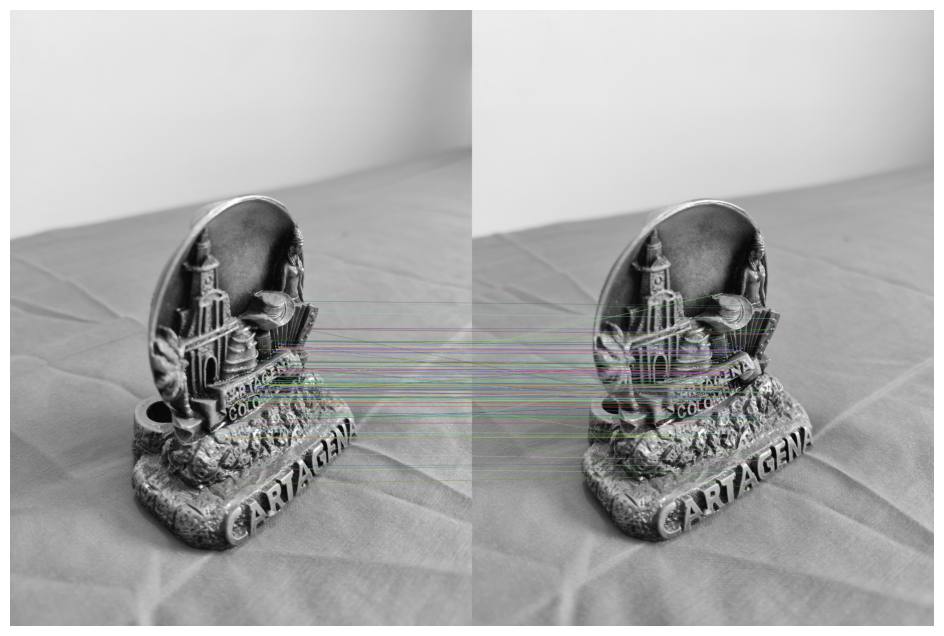

In [36]:
imagen1 = cv.imread(imagenes[0], cv.IMREAD_GRAYSCALE)
imagen2 = cv.imread(imagenes[1], cv.IMREAD_GRAYSCALE) #-> se tuvo un buen emparejamiento

#imagen1 = cv.imread(imagenes[5], cv.IMREAD_GRAYSCALE)
#imagen2 = cv.imread(imagenes[6], cv.IMREAD_GRAYSCALE) #-> se tuvo un emparejamiento regular

#imagen1 = cv.imread(imagenes[15], cv.IMREAD_GRAYSCALE)
#imagen2 = cv.imread(imagenes[16], cv.IMREAD_GRAYSCALE) #-> el emparejamiento fue malo (algunas caracteristicas no se emparejaron)

#imagen1 = cv.imread(imagenes[-2], cv.IMREAD_GRAYSCALE)
#imagen2 = cv.imread(imagenes[-1], cv.IMREAD_GRAYSCALE) #-> el emparejamiento fue bueno

#se crea el detector sift
orb = cv.ORB_create(nfeatures=500)
keypoints1, descriptors1 = orb.detectAndCompute(imagen1, None)
keypoints2, descriptors2 = orb.detectAndCompute(imagen2, None)

#BFMatcher
bf = cv.BFMatcher(cv.NORM_HAMMING, crossCheck=True)
matches = bf.match(descriptors1, descriptors2)

# Ordenar los emparejamientos por distancia
matches = sorted(matches, key=lambda x: x.distance)


img_matches = cv.drawMatches(imagen1, keypoints1, imagen2, keypoints2, matches, None, flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

plt.figure(figsize=(12, 8))
plt.imshow(img_matches, cmap='gray')
plt.axis('off')
plt.show()


### Intento de emparejamiento, usando imagen en gris, con roi, cambios de contraste y brillo, sift y flann

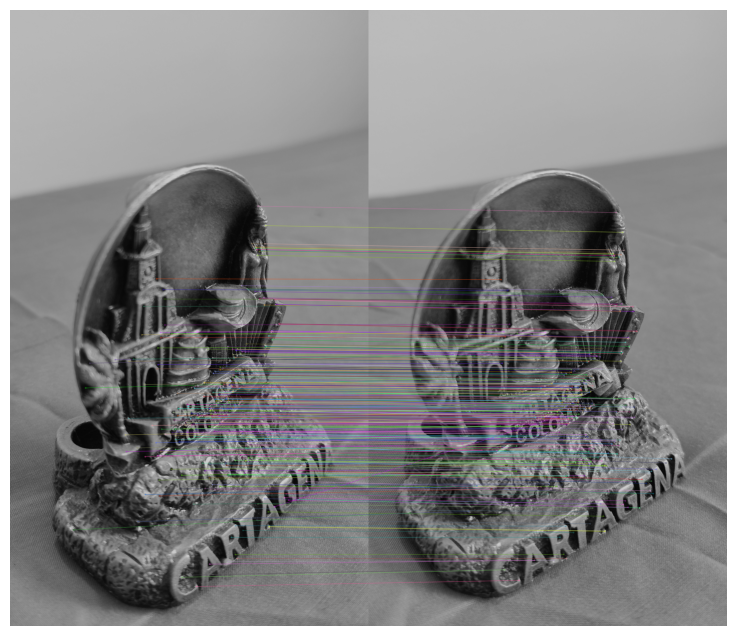

In [37]:
imagen1 = cv.imread(imagenes[0], cv.IMREAD_GRAYSCALE)
imagen2 = cv.imread(imagenes[1], cv.IMREAD_GRAYSCALE) #-> se tuvo un muy buen emparejamiento

#imagen1 = cv.imread(imagenes[5], cv.IMREAD_GRAYSCALE)
#imagen2 = cv.imread(imagenes[6], cv.IMREAD_GRAYSCALE) #-> se tuvo un muy buen emparejamiento

#imagen1 = cv.imread(imagenes[15], cv.IMREAD_GRAYSCALE)
#imagen2 = cv.imread(imagenes[16], cv.IMREAD_GRAYSCALE) #-> el emparejamiento fue bueno

#imagen1 = cv.imread(imagenes[-2], cv.IMREAD_GRAYSCALE)
#imagen2 = cv.imread(imagenes[-1], cv.IMREAD_GRAYSCALE) #-> el emparejamiento fue bueno


#preprocesamiento:
height, width = imagen1.shape[:2]
roi_width, roi_height = int(width * 0.62), int(height * 0.8)
x1, y1 = (width - roi_width) // 2, (height - roi_height) // 2
x2, y2 = x1 + roi_width, y1 + roi_height

roi1 = imagen1[y1:y2, x1:x2]
roi1 = cv.convertScaleAbs(roi1, alpha=0.8, beta=1.2)

roi2 = imagen2[y1:y2, x1:x2]
roi2 = cv.convertScaleAbs(roi2, alpha=0.8, beta=1.2)


#se crea el detector sift
sift = cv.SIFT_create(nfeatures=1000)
keypoints1, descriptors1 = sift.detectAndCompute(roi1, None)
keypoints2, descriptors2 = sift.detectAndCompute(roi2, None)

#FLANN parameters
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 10)
search_params = dict(checks=50)

flann = cv.FlannBasedMatcher(index_params, search_params)
matches = flann.knnMatch(descriptors1, descriptors2, k=2)

good = []
for m, n in matches:
    if m.distance < 0.7*n.distance: #seleccionar los mejores emparejamientos (menor distancia)
        good.append(m)

img_matches = cv.drawMatches(roi1, keypoints1, roi2, keypoints2, good, None, flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

plt.figure(figsize=(12, 8))
plt.imshow(img_matches, cmap='gray')
plt.axis('off')
plt.show()


### Intento de emparejamiento, usando imagen en gris, con roi, cambios de contraste y brillo, orb y bfmatcher

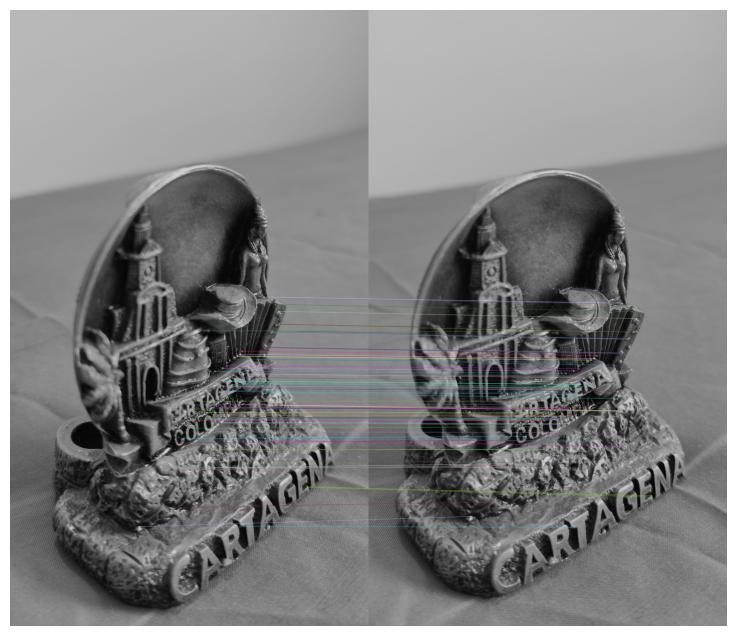

In [38]:
imagen1 = cv.imread(imagenes[0], cv.IMREAD_GRAYSCALE)
imagen2 = cv.imread(imagenes[1], cv.IMREAD_GRAYSCALE) #-> se tuvo un buen emparejamiento

#imagen1 = cv.imread(imagenes[5], cv.IMREAD_GRAYSCALE)
#imagen2 = cv.imread(imagenes[6], cv.IMREAD_GRAYSCALE) #-> se tuvo un buen emparejamiento

#imagen1 = cv.imread(imagenes[15], cv.IMREAD_GRAYSCALE)
#imagen2 = cv.imread(imagenes[16], cv.IMREAD_GRAYSCALE) #-> se tuvo un emparejamiento regular

#imagen1 = cv.imread(imagenes[-2], cv.IMREAD_GRAYSCALE)
#imagen2 = cv.imread(imagenes[-1], cv.IMREAD_GRAYSCALE) #-> el emparejamiento fue bueno

height, width = imagen1.shape[:2]
roi_width, roi_height = int(width * 0.62), int(height * 0.8)
x1, y1 = (width - roi_width) // 2, (height - roi_height) // 2
x2, y2 = x1 + roi_width, y1 + roi_height

roi1 = imagen1[y1:y2, x1:x2]
roi1 = cv.convertScaleAbs(roi1, alpha=0.8, beta=1.2)

roi2 = imagen2[y1:y2, x1:x2]
roi2 = cv.convertScaleAbs(roi2, alpha=0.8, beta=1.2)

#se crea el detector sift
orb = cv.ORB_create(nfeatures=1000)
keypoints1, descriptors1 = orb.detectAndCompute(roi1, None)
keypoints2, descriptors2 = orb.detectAndCompute(roi2, None)


#BFMatcher
bf = cv.BFMatcher(cv.NORM_HAMMING, crossCheck=True)
matches = bf.match(descriptors1, descriptors2)

# Ordenar los emparejamientos por distancia
matches = sorted(matches, key=lambda x: x.distance)
matches = matches[:100]


img_matches = cv.drawMatches(roi1, keypoints1, roi2, keypoints2, matches, None, flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

plt.figure(figsize=(12, 8))
plt.imshow(img_matches, cmap='gray')
plt.axis('off')
plt.show()

## ---

Después de realizar las pruebas, el mejor emparejamiento fue el de sift, usando flann, con las imagenes procesadas con cambios en el brillo y el contraste. Además de usando un roi

# Resolución de los puntos 2, 3 y 4

## Punto 2, preprocesamiento de las imagenes

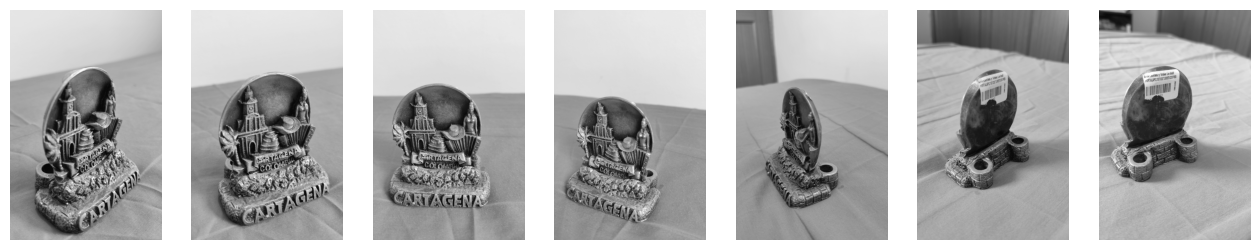

In [39]:
imagenes_procesadas = []
for imagen in imagenes:
    img = cv.imread(imagen, cv.IMREAD_GRAYSCALE)
    height, width = img.shape[:2]
    roi_width, roi_height = int(width * 0.7), int(height * 0.8)
    x1, y1 = (width - roi_width) // 2, (height - roi_height) // 2
    x2, y2 = x1 + roi_width, y1 + roi_height

    roi = img[y1:y2, x1:x2]
    roi = cv.convertScaleAbs(roi, alpha=0.8, beta=1.2)
    imagenes_procesadas.append(roi)

#Se muestran algunas de las imagenes a procesadas
fig, axes = plt.subplots(1, 7, figsize=(16, 4))
indices = [0, 2, 6, 8, 12, 16, 17]
for ax, idx in zip(axes, indices):
    ax.imshow(imagenes_procesadas[idx], cmap='gray')
    ax.axis('off')
plt.show()

# Punto 3, Deteccion de características y emparejamiento

In [40]:
lista_descriptores = []
lista_keys = []

sift = cv.SIFT_create(nfeatures=2000)
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 10)
search_params = dict(checks=50)

flann = cv.FlannBasedMatcher(index_params, search_params)

for i in tqdm(range(len(imagenes_procesadas)), desc="Calculando características"):
    keypoints, descriptors = sift.detectAndCompute(imagenes_procesadas[i], None)
    lista_descriptores.append(descriptors)
    lista_keys.append(keypoints)
    
lista_matches = []
imagenes_match = []

for i in tqdm(range(len(lista_descriptores)-1), desc="Emparejando características"):
    matches = flann.knnMatch(lista_descriptores[i], lista_descriptores[i+1], k=2)
    good = []
    for m, n in matches:
        if m.distance < 0.85*n.distance: #seleccionar los mejores emparejamientos (menor distancia)
            good.append(m)

    lista_matches.append(good)

    img_matches = cv.drawMatches(imagenes_procesadas[i], lista_keys[i], imagenes_procesadas[i+1], lista_keys[i+1], good, None, flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
    imagenes_match.append(img_matches)

Emparejando características: 100%|██████████| 25/25 [00:04<00:00,  5.28it/s]


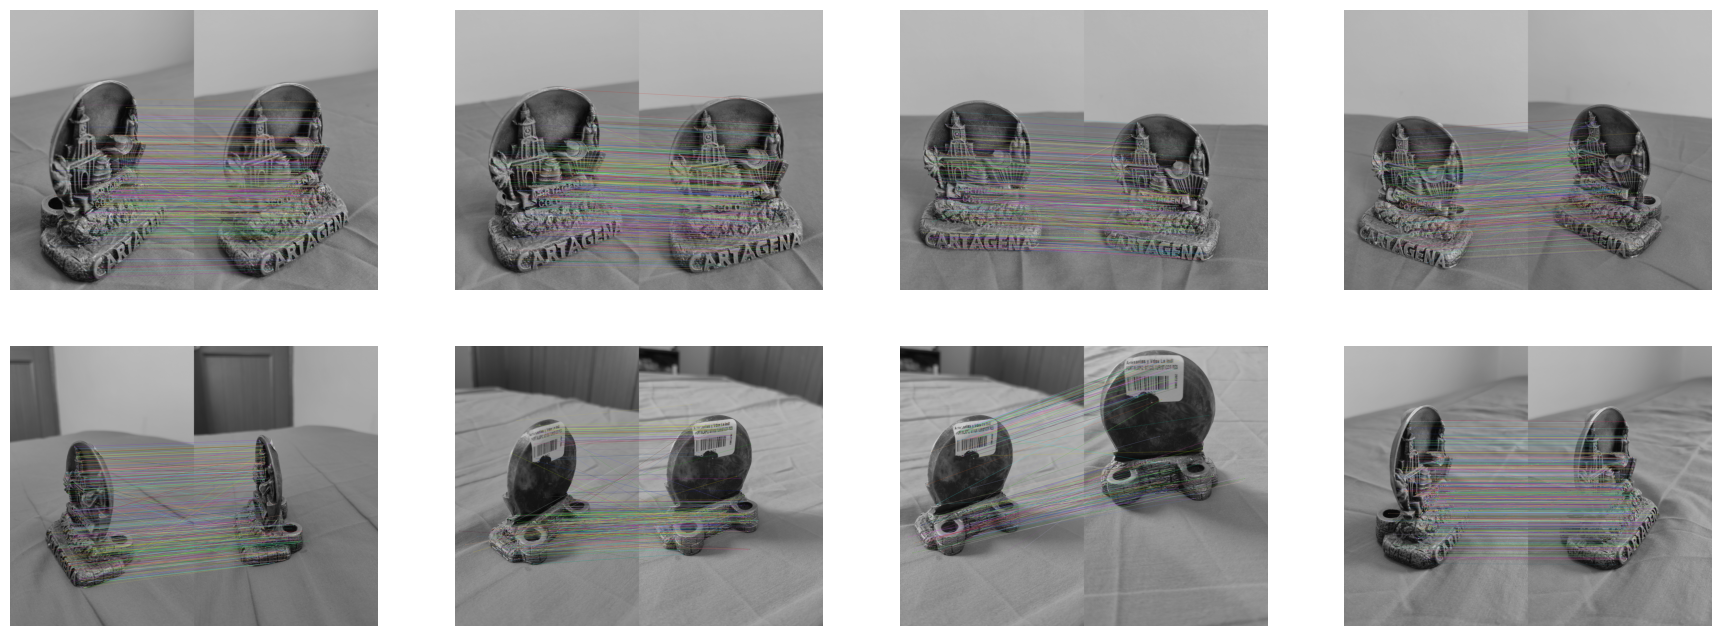

In [41]:
#se muestran algunas de las imagenes emparejadas
fig, axes = plt.subplots(2, 4, figsize=(22, 8))
indices = [0, 2, 6, 8, 12, 16, 17, -1]
for ax, idx in zip(axes.flatten(), indices):
    ax.imshow(imagenes_match[idx], cmap='gray')
    ax.axis('off')
plt.show()

# Punto 4, Estimación de matriz fundamental, escencial, traslación y rotación.

In [42]:
matriz_fundamental = []
matriz_escencial = []
rotaciones = []
traslaciones = []

#matriz de camara
K = np.array([[2.56328312e+03, 0.00000000e+00, 5.16460585e+02],
              [0.00000000e+00, 1.35537282e+03, 2.10701845e+02],
              [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]])


for i in tqdm(range(0, len(lista_keys)-1), desc="Calculando matrices"):

    pts1 = np.float32([lista_keys[i][m.queryIdx].pt for m in lista_matches[i]])
    pts2 = np.float32([lista_keys[i+1][m.trainIdx].pt for m in lista_matches[i]])

    F, mask = cv.findFundamentalMat(pts1, pts2, cv.FM_RANSAC)
    matriz_fundamental.append(F)

    E, mask = cv.findEssentialMat(pts1, pts2, K, cv.RANSAC, prob=0.99999, threshold=0.1)
    matriz_escencial.append(E)

    _, R, t, _ = cv.recoverPose(E, pts1, pts2, K)
    rotaciones.append(R)
    traslaciones.append(t)

print(f"Se calcularon {len(matriz_fundamental)} matrices fundamentales")
print(f"Se calcularon {len(matriz_escencial)} matrices esenciales")
print(f"Se calcularon {len(rotaciones)} rotaciones")
print(f"Se calcularon {len(traslaciones)} traslaciones")

Calculando matrices: 100%|██████████| 25/25 [00:08<00:00,  3.02it/s]

Se calcularon 25 matrices fundamentales
Se calcularon 25 matrices esenciales
Se calcularon 25 rotaciones
Se calcularon 25 traslaciones


In [43]:
#matrices de proyeccion
proyeccion = []
proyeccion.append(K @ np.hstack((np.eye(3), np.zeros((3, 1)))))
for i in range(0, len(rotaciones)):
    proyeccion.append(K @ np.hstack((rotaciones[i], traslaciones[i])))

print(len(proyeccion))


26


In [44]:
triangulaciones = []
for i in tqdm(range(0, len(lista_keys)-1), desc="Triangulando"):
    pts1 = np.float32([lista_keys[i][m.queryIdx].pt for m in lista_matches[i]])
    pts2 = np.float32([lista_keys[i+1][m.trainIdx].pt for m in lista_matches[i]])

    puntos_3d = cv.triangulatePoints(proyeccion[i], proyeccion[i+1], pts1.T, pts2.T).T
    puntos_3d = cv.convertPointsFromHomogeneous(puntos_3d)[:, 0, :]
    triangulaciones.append(puntos_3d)

Triangulando: 100%|██████████| 25/25 [00:00<00:00, 348.40it/s]
